# Analyze runtimes

Analyze the runtimes of the injections we did

In [13]:
import psutil
p = psutil.Process()
p.cpu_affinity([0])
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np 
import matplotlib.pyplot as plt

params = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(params)
import copy

In [14]:
outdirs = {"TF2": "../injections/outdir_TF2/",
           "NRTv2": "../injections/outdir_NRTv2/"}

In [15]:
runtimes_dict = {} 
for name in outdirs.keys():
    outdir = outdirs[name]
    runtimes = []
    for subdir in os.listdir(outdir):
        if not os.path.exists(outdir + subdir + "/runtime.txt"):
            continue
        
        with open(outdir + subdir + "/runtime.txt", "r") as f:
            runtime = float(f.read())
            runtimes.append(runtime)
            
    runtimes_dict[name] = np.array(runtimes)

## Runtime as a function of time

Is there a clear trend in time, because of the cluster?

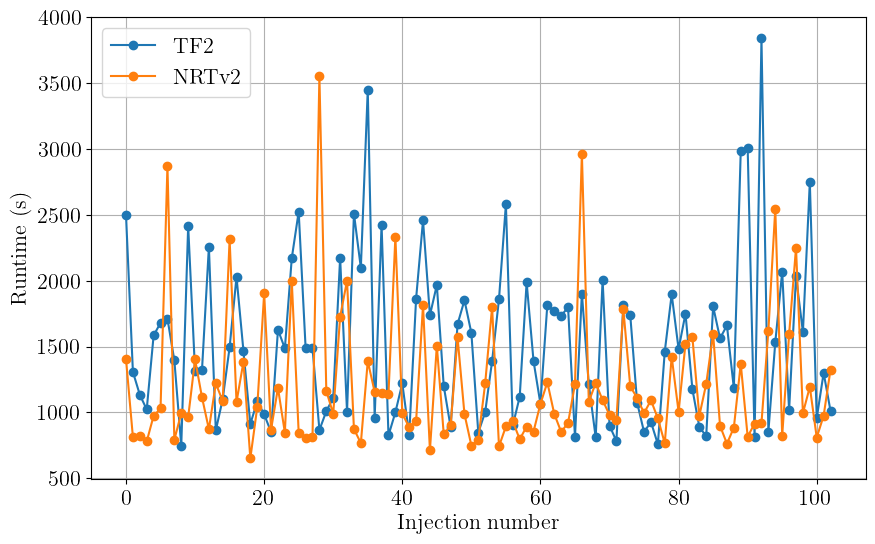

In [16]:
minutes = False

plt.figure(figsize=(10, 6))
for name, runtimes in runtimes_dict.items():
    values = copy.deepcopy(runtimes)
    if minutes:
        runtimes /= 60
        ylabel = "Runtime (min)"
    else:
        ylabel = "Runtime (s)"
    plt.plot(np.arange(len(runtimes)), runtimes, "-o", label=name)

plt.legend()
plt.xlabel("Injection number")
plt.ylabel(ylabel)
plt.show()

## Histogram

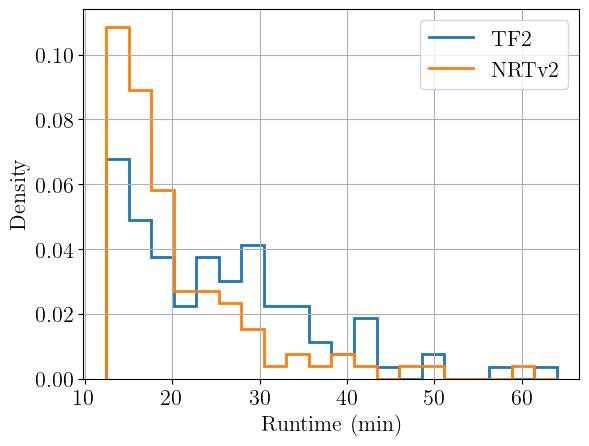

In [17]:
minutes = True

if minutes:
    denominator = 60
else:
    denominator = 1

hist_TF2, edges = np.histogram(runtimes_dict["TF2"] / denominator, bins=20, density=True)
hist_NRTv2, _ = np.histogram(runtimes_dict["NRTv2"] / denominator, bins=edges, density=True)

if minutes:
    xlabel = "Runtime (min)"
else:
    xlabel = "Runtime (s)"

stairs_kwargs = {"linewidth": 2}

plt.stairs(hist_TF2, edges, label = "TF2", **stairs_kwargs)
plt.stairs(hist_NRTv2, edges, label = "NRTv2", **stairs_kwargs)

plt.legend()
plt.xlabel(xlabel)
plt.ylabel("Density")
plt.show()

## Final numbers

In [18]:
for name, runtimes in runtimes_dict.items():
    print(f"{name}: mean +/- std: {np.mean(runtimes / denominator):.2f} +/- {np.std(runtimes / denominator):.2f} minutes")
    print(f"{name}: median {np.median(runtimes / denominator):.2f} minutes")

TF2: mean +/- std: 25.41 +/- 10.46 minutes
TF2: median 24.48 minutes
NRTv2: mean +/- std: 20.12 +/- 8.58 minutes
NRTv2: median 16.73 minutes


## Runtimes for compilation and initializing the likelihood

In [19]:
runtimes_compilation_filename = "../data/runtimes_compilation.txt"
runtimes_compilation = np.loadtxt(runtimes_compilation_filename, delimiter=",")

compilation_mean, compilation_std = np.mean(runtimes_compilation), np.std(runtimes_compilation)
# print(f"Compilation: mean +/- std: {compilation_mean:.2f} +/- {compilation_std:.2f} seconds")
print(f"Compilation: mean +/- std: {compilation_mean / 60:.2f} +/- {compilation_std / 60:.2f} minutes")

# Below, neglect the uncertainty, since small w.r.t. the uncertainty coming from the different injection runs

compilation_mean_minutes = compilation_mean / 60

Compilation: mean +/- std: 2.59 +/- 0.33 minutes


## Final numbers, subtracting compilation overhead:

In [20]:
for name, runtimes in runtimes_dict.items():
    my_mean = np.mean(runtimes / denominator) - compilation_mean_minutes
    print(f"{name}: mean +/- std: {my_mean:.2f} +/- {np.std(runtimes / denominator):.2f} minutes")
    my_median = np.median(runtimes / denominator) - compilation_mean_minutes
    print(f"{name}: median {my_median:.2f} minutes")

TF2: mean +/- std: 22.81 +/- 10.46 minutes
TF2: median 21.88 minutes
NRTv2: mean +/- std: 17.53 +/- 8.58 minutes
NRTv2: median 14.14 minutes
